# Plot connectivity along the shelf (east and west)

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cft
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
from pathlib import Path
module_path = str(Path.cwd().parents[0] )
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
import custom_functions as cf

/home/561/hd4873/parcel_runs/antarctic_connectivity_paper


In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 18,Total memory: 220.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42053,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 18
Started: Just now,Total memory: 220.00 GiB
Comm: tcp://127.0.0.1:44923,Total threads: 3
Dashboard: /proxy/43217/status,Memory: 36.67 GiB
Nanny: tcp://127.0.0.1:33615,


**Modify the curl colormap to remove whitespace in middle.**

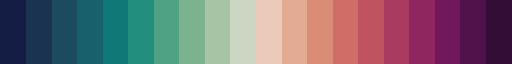

In [5]:
# Remove the middle 10% of the curl colormap
interval = np.hstack([np.linspace(0, 0.45), np.linspace(0.55, 1)])
colors = cm.cm.curl(interval)
cmap = LinearSegmentedColormap.from_list('name', colors, N=20)
cmap

**Define some map data for plotting.**

In [6]:
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht[:1000,:] 
hu = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').hu[:509,:] 
land_mask = (hu*0).fillna(1)
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
hu_shelf, shelf_mask = cf.shelf_mask_isobath(hu)

land_mask_masked = land_mask.where(land_mask == 1, np.nan)
land_mask[300:, 800:1000] = 0
land_mask[355:,5:140] = 0
land_mask[225:, 1800:2000] = 0

**Read in connectivity data.**

In [7]:
# connectivity mask
mask = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/zonal_connectivity_mask_ht.nc')

# particle counts
outfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/zonal_conn/zonal_connectivity_counts_NEW.nc'
connectivity = xr.open_dataset(outfile)
connectivity

<xarray.Dataset>
Dimensions:         (shelf_basin: 21, source_region: 6)
Coordinates:
  * shelf_basin     (shelf_basin) object 'EA shelf 01' ... 'EA shelf 10'
  * source_region   (source_region) object 'shelf_east' ... 'shelf_asc'
Data variables:
    conn_count      (shelf_basin, source_region) float64 ...
    conn_trans      (shelf_basin, source_region) float64 ...
    conn_count_pct  (shelf_basin, source_region) float64 ...
    conn_trans_pct  (shelf_basin, source_region) float64 ...

In [8]:
# save count/percent values to mask for ease with plotting
var = 'conn_trans_pct'

# from shelf east
connectivitytmp01 = mask.basins.copy(deep=True)
connectivitytmp01 = connectivitytmp01.where(connectivitytmp01 < 500, np.nan)
for i, bas in enumerate(np.unique(mask.basins)[0:21]):
    connectivitytmp01 = connectivitytmp01.where(connectivitytmp01 != bas, connectivity[f'{var}'][i, 0])

# from asc east
connectivitytmp02 = mask.basins.copy(deep=True)
connectivitytmp02 = connectivitytmp02.where(connectivitytmp02 < 500, np.nan)
for i, bas in enumerate(np.unique(mask.basins)[0:21]):
    connectivitytmp02 = connectivitytmp02.where(connectivitytmp02 != bas, connectivity[f'{var}'][i, 1])
    
# from asc north
connectivitytmp03 = mask.basins.copy(deep=True)
connectivitytmp03 = connectivitytmp03.where(connectivitytmp03 < 500, np.nan)
for i, bas in enumerate(np.unique(mask.basins)[0:21]):
    connectivitytmp03 = connectivitytmp03.where(connectivitytmp03 != bas, connectivity[f'{var}'][i,2])
    
# from asc west
connectivitytmp04 = mask.basins.copy(deep=True)
connectivitytmp04 = connectivitytmp04.where(connectivitytmp04 < 500, np.nan)
for i, bas in enumerate(np.unique(mask.basins)[0:21]):
    connectivitytmp04 = connectivitytmp04.where(connectivitytmp04 != bas, connectivity[f'{var}'][i, 3])
    
# from shelf west
connectivitytmp05 = mask.basins.copy(deep=True)
connectivitytmp05 = connectivitytmp05.where(connectivitytmp05 < 500, np.nan)
for i, bas in enumerate(np.unique(mask.basins)[0:21]):
    connectivitytmp05 = connectivitytmp05.where(connectivitytmp05 != bas, connectivity[f'{var}'][i,4])
        
# shelf north to asc
connectivitytmp06 = mask.basins.copy(deep=True)
connectivitytmp06 = connectivitytmp06.where(connectivitytmp06 < 500, np.nan)
for i, bas in enumerate(np.unique(mask.basins)[0:21]):
    connectivitytmp06 = connectivitytmp06.where(connectivitytmp06 != bas, connectivity[f'{var}'][i,5])

In [9]:
norme = plt.Normalize(0, connectivity.conn_trans_pct[:,:].max())
normw  = plt.Normalize(-connectivity.conn_trans_pct[:,:].max(), 0)
norm  = plt.Normalize(-100, 100)

Replace values at Antarctic Peninsula with those from adjusted latitude. 

In [10]:
connectivity.conn_trans_pct[12,0] = 50.10876656569485
connectivity.conn_trans_pct[13,4] = 0.26983869377409864

## -----------------------------------------------------

## Plot Figure

## -----------------------------------------------------

#### **First save background as a raster image.**

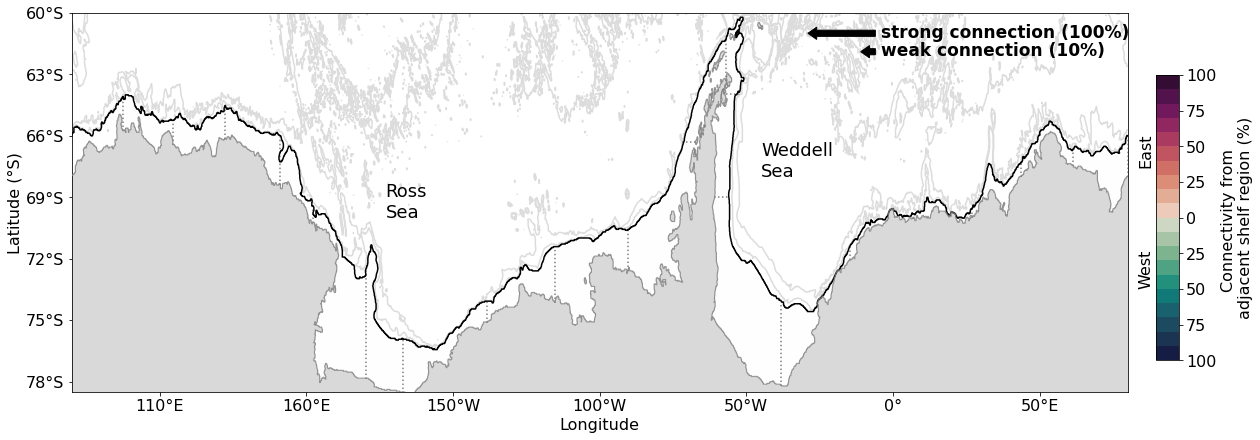

In [14]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,6))
dval = 5
var = 'conn_trans_pct'
hl=3
hw=0.6

ax.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], colors='k', alpha=1, linewidths=1.5, zorder=3,)
ax.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], colors='grey', alpha=0.8, linewidths=1.2, zorder=3)
ax.contourf(xu_ocean, yu_ocean, land_mask_masked.values, color='grey', cmap='Greys',zorder=2)
ax.contour(ht.xt_ocean, ht.yt_ocean, ht, levels=[2000,3000,5000], linewdiths=0.4, colors='gainsboro',zorder=0)
cb = ax.pcolormesh(connectivitytmp04.xt_ocean, connectivitytmp04.yt_ocean, connectivitytmp05,cmap=cmap, alpha=1, zorder=0, vmin=-100, vmax=100)
ax.pcolormesh(connectivitytmp04.xt_ocean, connectivitytmp04.yt_ocean, connectivitytmp05,cmap='RdGy', alpha=1, zorder=0, vmin=-10000, vmax=10000)
valemin = 1

for i in range(21):
    bas = np.unique(mask.basins)[0:21][i]
    right = xu_ocean[np.where(mask.basins == bas)[1]].max()
    left = xu_ocean[np.where(mask.basins == bas)[1]].min()
    landid = np.where(land_mask.sel(xu_ocean=right, method='nearest') == 1)[0][-1]
    shelfid = np.where(shelf_mask.sel(xu_ocean=right, method='nearest') == 1)[0][-1]
    latmid = (yu_ocean[landid]+yu_ocean[shelfid])/2

    if i == 10:
        valw = connectivity[f'{var}'][i, 0]
        vale = connectivity[f'{var}'][i+1, 4]
        latmid = yu_ocean[np.where(mask.basins == bas)[0]].max()
        leftid = np.where(shelf_mask.sel(xu_ocean=slice(-90, -65)).sel(yu_ocean = latmid, method='nearest') == 1)[0][0]
        rightid = np.where(land_mask.sel(xu_ocean=slice(-90, -65)).sel(yu_ocean = latmid, method='nearest') == 1)[0][0]
        left = shelf_mask.sel(xu_ocean=slice(-90, -65)).xu_ocean[leftid]
        right = land_mask.sel(xu_ocean=slice(-90, -65)).xu_ocean[rightid]
        lonmid = (right+left)/2
        ax.plot([-72, -67], [-66.3, -66.3], linestyle=':', c='grey')
    elif i == 12:
        valw = connectivity[f'{var}'][i, 0]
        vale = connectivity[f'{var}'][i+1, 4]
        latmid = yu_ocean[np.where(mask.basins == bas)[0]].min()
        rightid = np.where(shelf_mask.sel(xu_ocean=slice(-65, -40)).sel(yu_ocean = latmid, method='nearest') == 1)[0][-1]
        leftid = np.where(land_mask.sel(xu_ocean=slice(-65, -40)).sel(yu_ocean = latmid, method='nearest') == 1)[0][-1]
        left = shelf_mask.sel(xu_ocean=slice(-65, -40)).xu_ocean[leftid]
        right = land_mask.sel(xu_ocean=slice(-65, -40)).xu_ocean[rightid]
        lonmid = (right+left)/2
        ax.plot([-57, -52], [-63.98, -63.98], linestyle=':', c='grey')
    elif i == 13:
        valw = connectivity[f'{var}'][i, 0]
        vale = connectivity[f'{var}'][i+1, 4]
        latmid = yu_ocean[np.where(mask.basins == bas)[0]].min()
        rightid = np.where(shelf_mask.sel(xu_ocean=slice(-65, -40)).sel(yu_ocean = latmid, method='nearest') == 1)[0][-1]
        leftid = np.where(land_mask.sel(xu_ocean=slice(-65, -40)).sel(yu_ocean = latmid, method='nearest') == 1)[0][-1]
        left = shelf_mask.sel(xu_ocean=slice(-65, -40)).xu_ocean[leftid]
        right = land_mask.sel(xu_ocean=slice(-65, -40)).xu_ocean[rightid]
        lonmid = (right+left)/2
        ax.plot([-61, -56], [-69, -69], linestyle=':', c='grey')
    elif i == 20:
        vale = connectivity[f'{var}'][0, 4]
        valw = connectivity[f'{var}'][i, 0]
        x_values = [right, right]
        y_values = [yu_ocean[landid], yu_ocean[shelfid]]
        ax.plot(x_values, y_values, linestyle=':', c='grey')
        
    else:
        valw = connectivity[f'{var}'][i, 0]
        vale = connectivity[f'{var}'][i+1, 4]
        x_values = [right, right]
        y_values = [yu_ocean[landid], yu_ocean[shelfid]]
        ax.plot(x_values, y_values, linestyle=':', c='grey')


ax.arrow(-6, -61, -100/dval, 0, width = 0.3,head_width=hw, head_length=hl, zorder=3, color ='k',)
ax.arrow(-6, -61.9, -10/dval, 0, width = 0.3,head_width=hw, head_length=hl, zorder=3, color ='k',)
ax.annotate('strong connection (100%)', (-4, -61.2), fontsize=17,fontweight='bold')
ax.annotate('weak connection (10%)', (-4, -62.1),  fontsize=17, fontweight='bold')

ax.set_ylim([-78.5, -60])
ax.set_xticks([-250,-200,-150,-100,-50,0,50],['110\u00B0E','160\u00B0E','150\u00B0W','100\u00B0W','50\u00B0W','0\u00B0','50\u00B0E'])
ax.set_yticks([-78,-75,-72,-69,-66,-63,-60],['78\u00B0S','75\u00B0S','72\u00B0S','69\u00B0S','66\u00B0S','63\u00B0S','60\u00B0S'])

ax.set_ylabel('Latitude (\u00B0S)', fontsize=16)
ax.tick_params(axis='y',labelsize=16)
ax.set_xlabel('Longitude', fontsize=16)
ax.tick_params(axis='x',labelsize=16)

# add location labels
ax.text(-173, -70, 'Ross\nSea', fontsize=18, fontweight='normal')
ax.text(-45, -68, 'Weddell\nSea', fontsize=18, fontweight='normal')

# Add a colorbar axis at right of figure
cbar_ax = fig.add_axes([1.0, 0.175, 0.02, 0.66])
# Draw the colorbar
cbar=fig.colorbar(cb, cax=cbar_ax, orientation='vertical', extend='neither')
cbar.set_ticks([-100,-75,-50,-25,0,25,50,75,100])
cbar.set_ticklabels([100,75,50,25,0,25,50,75,100], fontsize=16)
cbar.set_label('Connectivity from \nadjacent shelf region (%)', fontsize=16)
ax.text(1.01, 0.28, 'West', fontsize=16,fontweight='normal', rotation=90, transform=ax.transAxes)
ax.text(1.01, 0.6, 'East', fontsize=16,fontweight='normal', rotation=90, transform=ax.transAxes)

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
outfile = outdir + 'Fig07_zonal_conn_background_100norm.png'
fig.savefig(outfile, dpi=300, bbox_inches='tight')
outfile = outdir + 'Fig07_zonal_conn_updated.jpg'
#fig.savefig(outfile, dpi=150, bbox_inches='tight')


#### **Now save arrows as vector form PDF**

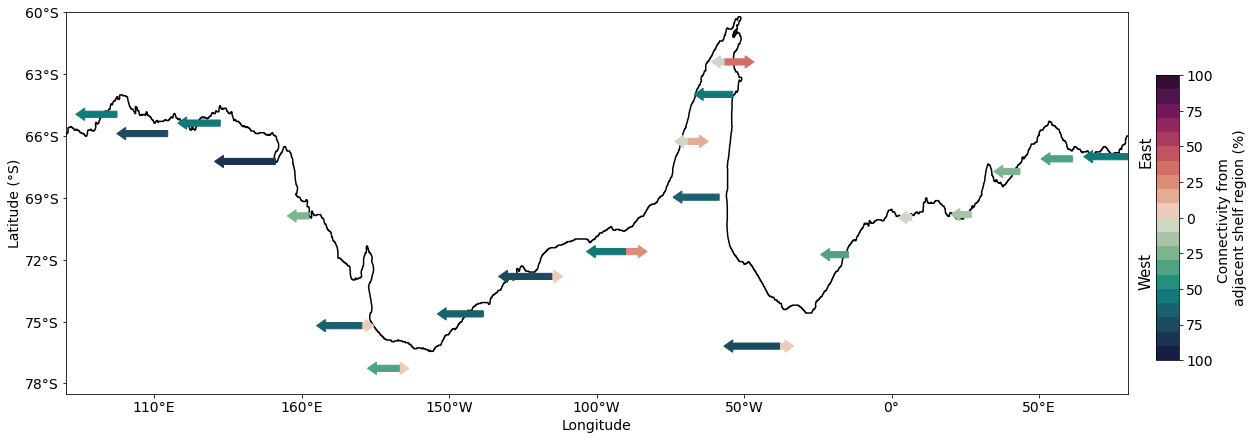

In [13]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,6))
dval = 5
var = 'conn_trans_pct'
hl = 3 
hw = 0.6 

ax.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], colors='k', alpha=1, linewidths=1.5, zorder=3,)
valemin = 1

for i in range(21):
    bas = np.unique(mask.basins)[0:21][i]
    right = xu_ocean[np.where(mask.basins == bas)[1]].max()
    left = xu_ocean[np.where(mask.basins == bas)[1]].min()
    landid = np.where(land_mask.sel(xu_ocean=right, method='nearest') == 1)[0][-1]
    shelfid = np.where(shelf_mask.sel(xu_ocean=right, method='nearest') == 1)[0][-1]
    latmid = (yu_ocean[landid]+yu_ocean[shelfid])/2

    if i == 10:
        valw = connectivity[f'{var}'][i, 0]
        vale = connectivity[f'{var}'][i+1, 4]
        latmid = yu_ocean[np.where(mask.basins == bas)[0]].max()
        leftid = np.where(shelf_mask.sel(xu_ocean=slice(-90, -65)).sel(yu_ocean = latmid, method='nearest') == 1)[0][0]
        rightid = np.where(land_mask.sel(xu_ocean=slice(-90, -65)).sel(yu_ocean = latmid, method='nearest') == 1)[0][0]
        left = shelf_mask.sel(xu_ocean=slice(-90, -65)).xu_ocean[leftid]
        right = land_mask.sel(xu_ocean=slice(-90, -65)).xu_ocean[rightid]
        lonmid = (right+left)/2
        if vale >= valemin:
            ax.arrow(lonmid, latmid, vale/dval, 0,width = 0.3, head_width=hw,head_length=hl, zorder=3, color =cmap(norm(vale)),)# transform = ccrs.PlateCarree())
        ax.arrow(lonmid, latmid, -valw/dval, 0, width = 0.3,head_width=hw, head_length=hl, zorder=3, color =cmap(norm(-valw)),)# transform = ccrs.PlateCarree()) head_width=0.5, head_length=1, 
    elif i == 12:
        valw = connectivity[f'{var}'][i, 0]
        vale = connectivity[f'{var}'][i+1, 4]
        latmid = yu_ocean[np.where(mask.basins == bas)[0]].min()
        rightid = np.where(shelf_mask.sel(xu_ocean=slice(-65, -40)).sel(yu_ocean = latmid, method='nearest') == 1)[0][-1]
        leftid = np.where(land_mask.sel(xu_ocean=slice(-65, -40)).sel(yu_ocean = latmid, method='nearest') == 1)[0][-1]
        left = shelf_mask.sel(xu_ocean=slice(-65, -40)).xu_ocean[leftid]
        right = land_mask.sel(xu_ocean=slice(-65, -40)).xu_ocean[rightid]
        lonmid = (right+left)/2
        if vale >= valemin:
            ax.arrow(lonmid, -63.98, vale/dval, 0,width = 0.3, head_width=hw,head_length=hl, zorder=3, color =cmap(norm(vale)),)# transform = ccrs.PlateCarree())
        ax.arrow(lonmid, -63.98, -valw/dval, 0, width = 0.3,head_width=hw, head_length=hl,zorder=3,color=cmap(norm(-valw)))# transform = ccrs.PlateCarree()) head_width=0.5, head_length=1, 

    elif i == 13:
        valw = connectivity[f'{var}'][i, 0]
        vale = connectivity[f'{var}'][i+1, 4]
        latmid = yu_ocean[np.where(mask.basins == bas)[0]].min()
        rightid = np.where(shelf_mask.sel(xu_ocean=slice(-65, -40)).sel(yu_ocean = latmid, method='nearest') == 1)[0][-1]
        leftid = np.where(land_mask.sel(xu_ocean=slice(-65, -40)).sel(yu_ocean = latmid, method='nearest') == 1)[0][-1]
        left = shelf_mask.sel(xu_ocean=slice(-65, -40)).xu_ocean[leftid]
        right = land_mask.sel(xu_ocean=slice(-65, -40)).xu_ocean[rightid]
        lonmid = (right+left)/2
        if vale >= valemin:
            ax.arrow(lonmid, latmid, vale/dval, 0,width = 0.3, head_width=hw,head_length=hl, zorder=3, color =cmap(norm(vale)),)# transform = ccrs.PlateCarree())
        ax.arrow(lonmid, latmid, -valw/dval, 0, width = 0.3,head_width=hw, head_length=hl, zorder=3, color =cmap(norm(-valw)))# transform = ccrs.PlateCarree()) head_width=0.5, head_length=1, 
    elif i == 20:
        vale = connectivity[f'{var}'][0, 4]
        valw = connectivity[f'{var}'][i, 0]
        if vale >= valemin:
            ax.arrow(-279.9, latmid, vale/dval, 0,width = 0.3, head_width=hw,head_length=hl, zorder=3, color =cmap(norm(vale)),)# transform = ccrs.PlateCarree())
        ax.arrow(right, latmid, -valw/dval, 0, width = 0.3,head_width=hw, head_length=hl, zorder=3, color =cmap(norm(-valw)),)# transform = ccrs.PlateCarree()) head_width=0.5, head_length=1, 
        x_values = [right, right]
        y_values = [yu_ocean[landid], yu_ocean[shelfid]]
        #ax.plot(x_values, y_values, linestyle=':', c='grey')
        
    else:
        valw = connectivity[f'{var}'][i, 0]
        vale = connectivity[f'{var}'][i+1, 4]
        if vale >= valemin:
            ax.arrow(right, latmid, vale/dval, 0,width = 0.3, head_width=hw,head_length=hl, zorder=3, color =cmap(norm(vale)),)# transform = ccrs.PlateCarree())
        ax.arrow(right, latmid, -valw/dval, 0, width = 0.3,head_width=hw, head_length=hl, zorder=3, color =cmap(norm(-valw)),)# transform = ccrs.PlateCarree()) head_width=0.5, head_length=1, 
        x_values = [right, right]
        y_values = [yu_ocean[landid], yu_ocean[shelfid]]
        #ax.plot(x_values, y_values, linestyle=':', c='grey')

ax.set_ylim([-78.5, -60])
ax.set_xticks([-250,-200,-150,-100,-50,0,50],['110\u00B0E','160\u00B0E','150\u00B0W','100\u00B0W','50\u00B0W','0\u00B0','50\u00B0E'])
ax.set_yticks([-78,-75,-72,-69,-66,-63,-60],['78\u00B0S','75\u00B0S','72\u00B0S','69\u00B0S','66\u00B0S','63\u00B0S','60\u00B0S'])

#ax4.grid()
ax.set_ylabel('Latitude (\u00B0S)', fontsize=14)
ax.tick_params(axis='y',labelsize=14)
ax.set_xlabel('Longitude', fontsize=14)
ax.tick_params(axis='x',labelsize=14)

# Add a colorbar axis at right of figure
cbar_ax = fig.add_axes([1.0, 0.175, 0.02, 0.66])
# Draw the colorbar
cbar=fig.colorbar(cb, cax=cbar_ax, orientation='vertical', extend='neither')
cbar.set_ticks([-100, -75,-50,-25,0,25,50,75, 100])#, rotation=270)
cbar.set_ticklabels([100, 75,50,25,0,25,50,75, 100], fontsize=14)#, rotation=270)
cbar.set_label('Connectivity from \nadjacent shelf region (%)', fontsize=14)#, rotation=270)
ax.text(1.01, 0.28, 'West', fontsize=15,fontweight='normal', rotation=90, transform=ax.transAxes)
ax.text(1.01, 0.6, 'East', fontsize=15,fontweight='normal', rotation=90, transform=ax.transAxes)

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
outfile = outdir + 'Fig07_zonal_conn_arrows_only_100norm.pdf'
fig.savefig(outfile, dpi = 300, bbox_inches='tight')


#### **These two figures (pdf of arrows and background raster) were then combined offline using InkScape so that the arrows could be rotated**

Note: I did it this way because I could not find a way to rotate the arrows in this map projection in such a way that accurately maintained the arrow length proportions. 